In [1]:
#  Generate a function of q value vs mortality on the test set, including a graph, from the continuous model

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle
from pandas import DataFrame
import matplotlib.pyplot as plt


In [3]:
train_orig = pd.read_csv('../scaled_sets/both_train_set_scaled.csv')
test_data = pd.read_csv("../scaled_sets/both_test_set_scaled.csv")
q_vals_path = '../dqn_models/both_dqn/dqn_normal_q_test.p'
q_vals_test = pickle.load(open( q_vals_path, "rb" ))
q_vals_test[:5]

[11.792866, 11.987059, 13.352243, 14.264527, 13.054862]

In [4]:
test_data.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input,reward
0,0.000000,3,7245052800,0.0,0.412568,0.0,0.0,0,1,0.278276,...,0.0,0.0,0.797351,0.939195,0.589916,0.750908,0.554500,0.0,4.0,0.0
1,0.222560,3,7245067200,0.0,0.412568,0.0,0.0,0,1,0.278276,...,0.0,0.0,0.831780,0.934543,0.674384,0.819589,0.580033,0.0,4.0,0.0
2,0.356608,3,7245081600,0.0,0.412568,0.0,0.0,0,1,0.278276,...,0.0,0.0,0.833222,0.656575,0.765423,0.939329,0.555033,0.0,2.0,0.0
3,0.452837,3,7245096000,0.0,0.412568,0.0,0.0,0,1,0.278276,...,0.0,0.0,0.834033,0.603831,0.783597,0.847073,0.545700,0.0,2.0,0.0
4,0.527957,3,7245110400,0.0,0.412568,0.0,0.0,0,1,0.278276,...,0.0,0.0,0.834836,0.603831,0.794059,0.811583,0.539533,0.0,2.0,0.0


In [5]:
# get the unique ids
unique_ids = test_data['icustayid'].unique()

In [6]:
# BELOW THREE CELLS ARE DIAGNOSTICS ON TRAIN-TEST SET DISTRIBUTION

In [7]:
# count = 0
# for i in unique_ids:
#     a= test_data[test_data['icustayid'] == i]
#     u = a[a['bloc'] ==1]['mortality']
#     x =  np.array(u)[0]
#     count += x
# print count/float(len(unique_ids))
# print count

In [8]:
# train_data = pd.read_csv('rl_train_set_small.csv')
# unique_ids2 = train_data['icustayid'].unique()

In [9]:
# count = 0
# for i in unique_ids2:
#     a= train_data[train_data['icustayid'] == i]
#     u = a[a['bloc'] ==1]['mortality']
#     x =  np.array(u)[0]
#     count += x
# print count/float(len(unique_ids2))

In [10]:
# define an action mapping - how to get an id representing the action from the (iv,vaso) tuple
# this is copied over from find_transition_matrix. Should really pass as argument - todo for when this
# is implemented properly!
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv,vaso)] = count
        count += 1

In [11]:
phys_score = np.mean(q_vals_test)
print(phys_score)

12.688288


In [12]:
pp = pd.Series(q_vals_test)
phys_df = pd.DataFrame(pp)

In [13]:
import copy
phys_df['mort'] = copy.deepcopy(np.array(test_data['mortality_90d']))

In [14]:
from scipy.stats import sem

In [15]:
bin_medians = []
mort = []
mort_std = []
i = -15
while i <= 20:
    count =phys_df.loc[(phys_df[0]>i-0.5) & (phys_df[0]<i+0.5)]
    try:
        res = sum(count['mort'])/float(len(count))
        if len(count) >=2:
            bin_medians.append(i)
            mort.append(res)
            mort_std.append(sem(count['mort']))
    except ZeroDivisionError:
        pass
    i += 1

In [16]:
def sliding_mean(data_array, window=2):
    new_list = []
    for i in range(len(data_array)):
        indices = range(max(i - window + 1, 0),
                        min(i + window + 1, len(data_array)))
        avg = 0
        for j in indices:
            avg += data_array[j]
        avg /= float(len(indices))
        new_list.append(avg)     
    return np.array(new_list)

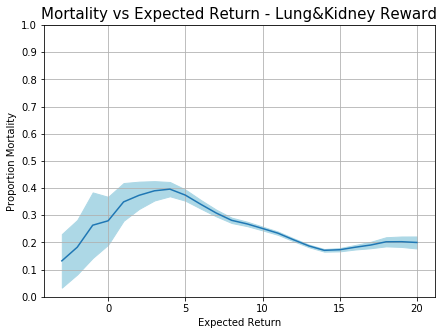

In [17]:
plt.figure(figsize=(7, 5))
plt.plot(bin_medians, sliding_mean(mort))
plt.fill_between(bin_medians, sliding_mean(mort) - 1*sliding_mean(mort_std),  
                 sliding_mean(mort) + 1*sliding_mean(mort_std), color='#ADD8E6')
plt.grid()
plt.xticks(range(0,21,5))
r = [float(i)/10 for i in range(0,11,1)]
_ = plt.yticks(r)
_ = plt.title("Mortality vs Expected Return - Lung&Kidney Reward", fontsize=15)  
_ = plt.ylabel("Proportion Mortality")
_ = plt.xlabel("Expected Return")

plt.savefig("../plots/both/mortality_expected_return.png")

In [18]:
len(phys_df[phys_df['mort']==1])/float(len(phys_df))

0.21466158591907095